In [2]:
from __future__ import division
from __future__ import print_function
import numpy as np
import pyedflib
import time

import utils

import matplotlib.pyplot as plt
import matplotlib.cm as cm
#%config InlineBackend.figure_format = 'retina'

In [2]:
#signal = file.readSignal(channel)
#fs = file.getSampleFrequency(channel)
#file._close()
#del file


# 256 Hz
# Filter low cutoff 0.3 Hz
# Filter high cutoff 100Hz
# Sleep stage: RK page size 20s
# entre 18 y 33 años
# For this subset, sleep spindles are scored by two experts (V4 and V5) on N2 epochs
# and on channel C3 with linked-ear reference.
# Channel C3 with linked-ear reference -> Channel 13 (0-based): EEG C3-CLE
# Keep in mind: We were developing based on a bipolar derivation, using F4-C4
# Spindles are marked in C3, so we could use a bipolar derivation F3-C3 with those marks to keep the same kind of signal.
# To obtain this derivation we should do (F3-CLE)-(C3-CLE) = channel 22 - channel 13.


# " As of now, the MASS contains one cohort (C1) of 200 complete-night recordings sampled at 256 Hz and split 
# into five subsets. The second subset (C1/SS2) contains 19 nights from young healthy subjects. For this subset,
# sleep spindles are scored by two experts (V4 and V5) on N2 epochs and on channel C3 with linked-ear reference.
# A complete description can be found in (O'Reilly et al. (2014) [1]). It should be noted that relatively low inter
# rater agreement is expected between these two scorers since V4 used traditional 
# AASM scoring rules whereas V5 used an approach similar to (Ray et al., 2010). 
# In this case, both broad-band EEG signals (0.35-35 Hz band) and sigma filtered 
# signals (11-17 Hz band) were used in scoring to facilitate the identification 
# of short duration, small amplitude or obscured (e.g., by delta waves or K-complexes)
# spindles. Also, no minimal spindle duration was used by V5 and four nights 
# (out of the 19) were not scored due to recordings that were judged to reflect poor quality sleep
# (e.g., alpha intrusions during N2) or intermittent signal quality/artifact (Fogel, personal communication). "
#  O’Reilly, C., and Nielsen, T. (2015). Automatic sleep spindle detection: benchmarking with fine temporal
# resolution using open science tools. https://www.frontiersin.org/articles/10.3389/fnhum.2015.00353/full

# DL arch for sleep events:
# Data The experiments were performed on MASS SS2 [24]:
# 19 records from 19 subjects (11 females, 8 males,  23.6
#  3.7 years old), sampled at 256 Hz. The spindles have
# been scored by expert E1 (resp. E2) over 19 records (resp.
# 15) using different guidelines [14] resulting in  550 (resp.
#  1100) scored spindles per record. For records scored
# by both E1 and E2 500 spindles per record exhibit IoU
# > 0 (Gaussian-like distribution, pic at 0.6). The 15 records
# annotated by E1 and E2 were used for spindles detection
# benchmark. For K-complex detection, and joint spindle and
# K-complex detection, the 19 records scored by E1 were used.

# Proposed approach The proposed approach was benchmarked
# on signal from channel C3.

# A 5 split cross validation was used. A
# split stands for 10 training, 2 validation and 3 testing records for spindle detection.

# Spindles Detectors were compared to 4 gold standards:
# events scored by E1, E2, the union and the intersection of
# events scored by both E1 and E2, see Figure 2.

In [20]:
path_edf_file = "ssdata_mass/register/01-02-0001 PSG.edf"
file = pyedflib.EdfReader(path_edf_file)
for channel in range(27):
    label = file.getLabel(channel)
    print("Channel "+str(channel)+": "+label)
file._close()

Channel 0: Resp nasal
Channel 1: EEG T4-CLE
Channel 2: EEG P3-CLE
Channel 3: EOG Left Horiz
Channel 4: EEG F4-CLE
Channel 5: EOG Right Horiz
Channel 6: ECG I
Channel 7: EEG T6-CLE
Channel 8: EEG Cz-CLE
Channel 9: EEG T5-CLE
Channel 10: EEG F7-CLE
Channel 11: EOG Upper Vertic
Channel 12: EEG T3-CLE
Channel 13: EEG C3-CLE
Channel 14: EEG Fp2-CLE
Channel 15: EEG O1-CLE
Channel 16: EEG Pz-CLE
Channel 17: EEG O2-CLE
Channel 18: EEG Fp1-CLE
Channel 19: EEG P4-CLE
Channel 20: EMG Chin
Channel 21: EEG Fpz-CLE
Channel 22: EEG F3-CLE
Channel 23: EEG C4-CLE
Channel 24: EEG A2-CLE
Channel 25: EEG F8-CLE
Channel 26: EOG Lower Vertic


In [2]:
# Read every register
fs = 256
channel_C3 = 13
for i in range(1,10):
    reg = '0'+str(i)
    path_edf_file = "ssdata_mass/register/01-02-00"+reg+" PSG.edf"
    file = pyedflib.EdfReader(path_edf_file)
    signal = file.readSignal(channel_C3)
    print("register",i," [S]:", len(signal)/fs)
    file._close()
for i in range(10,20):
    reg = str(i)
    path_edf_file = "ssdata_mass/register/01-02-00"+reg+" PSG.edf"
    file = pyedflib.EdfReader(path_edf_file)
    signal = file.readSignal(channel_C3)
    print("register",i," [s]:", len(signal)/fs)
    file._close()

register 1  [S]: 28958.0
register 2  [S]: 35020.0
register 3  [S]: 36764.0
register 4  [S]: 28006.0
register 5  [S]: 31246.0
register 6  [S]: 28992.0
register 7  [S]: 28304.0
register 8  [S]: 26848.0
register 9  [S]: 29836.0
register 10  [s]: 25932.0
register 11  [s]: 25436.0
register 12  [s]: 31534.0
register 13  [s]: 36376.0
register 14  [s]: 28178.0
register 15  [s]: 29116.0
register 16  [s]: 28342.0
register 17  [s]: 28344.0
register 18  [s]: 29556.0
register 19  [s]: 26394.0


Sampling freq 256
7413248 samples
Time axis:  0.0 28957.99609375


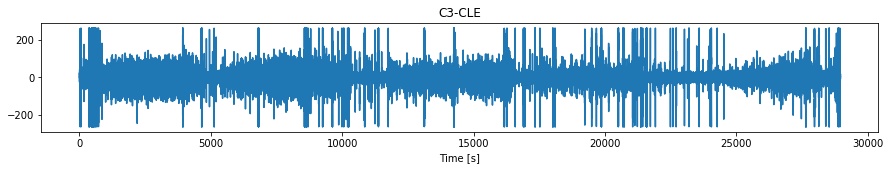

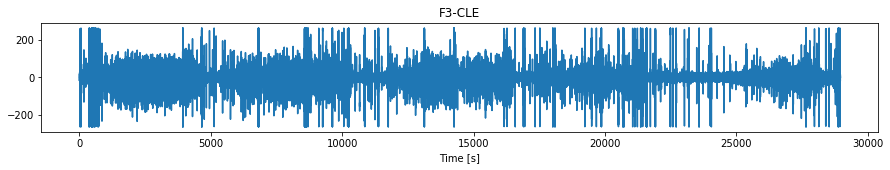

In [39]:
path_edf_file = "ssdata_mass/register/01-02-0001 PSG.edf"
file = pyedflib.EdfReader(path_edf_file)

channel_F3 = 22
channel_C3 = 13

signal_C3 = np.array(file.readSignal(channel_C3))
signal_F3 = np.array(file.readSignal(channel_F3))
#signal_F3C3 = signal_F3 - signal_C3

fs = file.getSampleFrequency(channel_C3)
print("Sampling freq", fs)
file._close()

n_samples = signal_C3.shape[0]
print(n_samples, "samples")
time_axis = np.arange(n_samples) / fs
print("Time axis: ", time_axis[0], time_axis[-1])

plt.figure(figsize=(15, 2))
plt.plot(time_axis, signal_C3)
plt.title('C3-CLE')
plt.xlabel('Time [s]')
plt.show()

plt.figure(figsize=(15, 2))
plt.plot(time_axis, signal_F3)
plt.title('F3-CLE')
plt.xlabel('Time [s]')
plt.show()

#plt.figure(figsize=(15, 2))
#plt.plot(time_axis, signal_F3C3)
#plt.title('F3-C3')
#plt.xlabel('Time [s]')
#plt.show()

Original size at 256Hz: 7245824 - Time in seconds: 28304.0
Time elapsed:  0.2587151527404785
New size at 200Hz: 5660800 - Time in seconds: 28304.0
256 size:  256
200 size:  200


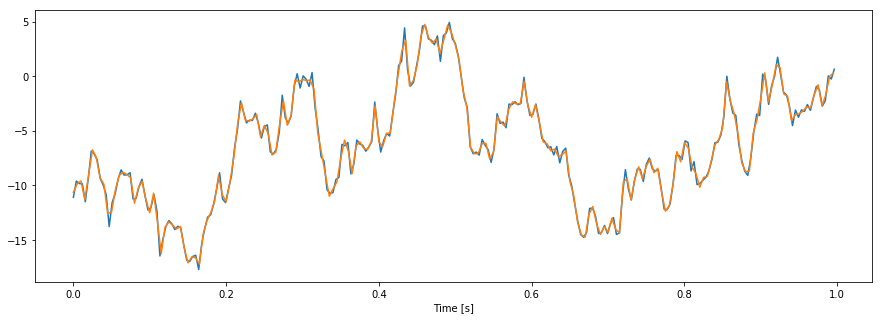

In [38]:
import scipy.signal as sp_signal
import math

old_freq = 256
new_freq = 200

n_256 = len(signal_C3)
print("Original size at 256Hz:", n_256, "- Time in seconds:", n_256/old_freq)

start_time = time.time()
gcd_freqs = math.gcd(new_freq,old_freq)
up = int(new_freq/gcd_freqs)
down = int(old_freq/gcd_freqs)
new_signal_C3 = sp_signal.resample_poly(signal_C3, up, down)
print("Time elapsed: ", time.time()-start_time)
n_200 = len(new_signal_C3)
print("New size at 200Hz:", n_200, "- Time in seconds:", n_200/new_freq)

# 256 -> 200
# Plot a random segment for comparison
seconds_length = 1
total_duration = (n_256/old_freq - seconds_length)
start_second = np.random.choice(int(total_duration))

start_256 = int(start_second*old_freq)
end_256 = start_256 + int(seconds_length*old_freq)
segment_256 = signal_C3[start_256:end_256]
print("256 size: ", len(segment_256))

start_200 = int(start_second*new_freq)
end_200 = start_200 + int(seconds_length*new_freq)
segment_200 = new_signal_C3[start_200:end_200]
print("200 size: ", len(segment_200))


plt.figure(figsize=(15, 5))
time_axis = np.arange(0, seconds_length, 1/old_freq)
plt.plot(time_axis,segment_256)
time_axis = np.arange(0, seconds_length, 1/new_freq)
plt.plot(time_axis,segment_200)
plt.xlabel('Time [s]')
plt.show()

Sampling freq 200


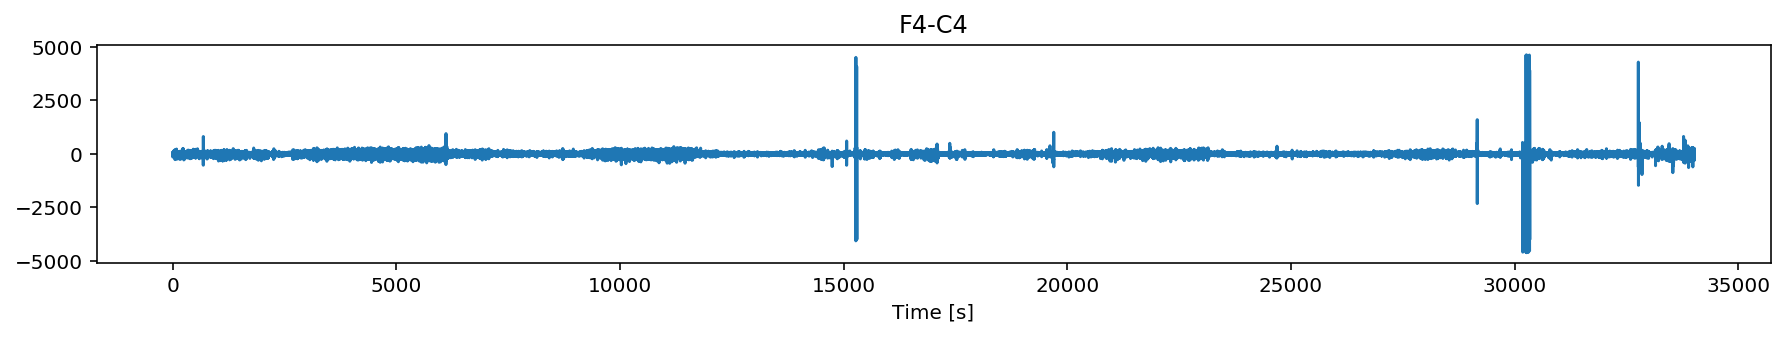

In [80]:
path_edf_file = "ssdata_inta/register/ALUR012904.rec"
file = pyedflib.EdfReader(path_edf_file)

channel_1 = 0
signal_1 = file.readSignal(channel_1)
fs = file.getSampleFrequency(channel_1)
print("Sampling freq", fs)
file._close()

n_samples = len(signal_1)
time_axis = np.arange(n_samples) / fs
plt.figure(figsize=(15, 2))
plt.plot(time_axis, signal_1)
plt.title('F4-C4')
plt.xlabel('Time [s]')
plt.show()

In [74]:
# Read stages
# Format of stages is onset | duration | description
path_edf_file = "ssdata_mass/label/states/01-02-0001 Base.edf"
file = pyedflib.EdfReader(path_edf_file)
print(file.annotations_in_file) # 1419
annotations = file.readAnnotations() # This is a 3-tuple
# first element is location in time
# second element is duration (always 20s)
# third element is stage
n = 1418
print("annotation: onset is %f    duration is %s    description is %s" % (annotations[0][n],annotations[1][n],annotations[2][n]))
file._close()

# First state has onset 
# Last state has onset 28920.761992, so it ends at 28940.761992
# But time axis has interval  (0.0 ; 28957.99609375) so we have to be careful. 
# We have to take into account the onset. The onset then is the time of beginning for page, asuming that
# t=0 is for the begining of the signal. We could crop the signal between the first onset and the last offset.

1419
annotation: onset is 28920.761992    duration is 19.9948120117    description is Sleep stage W


Sleep stage 4
S
l
e
e
p
 
s
t
a
g
e
 
4
single char: 4
1419
{'2', '3', '4', '?', 'R', 'W', '1'}
745


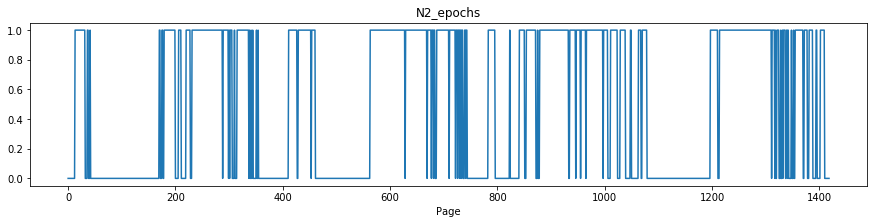

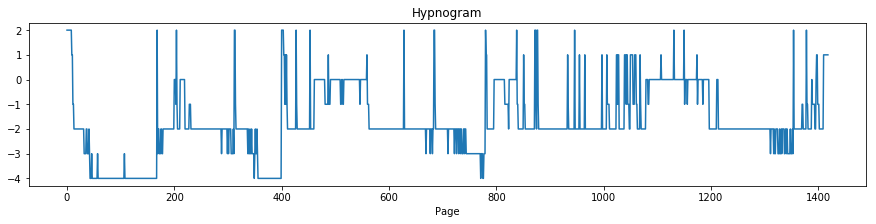

In [78]:
stages_str = annotations[2] # each element is <class 'numpy.str_'>
single_annot = stages_str[100]  #<class 'numpy.str_'>
print(single_annot)
for element in single_annot:
    print(element)
get_char = single_annot[-1]
print("single char:",get_char)

stages_str = annotations[2]
stages_char = [single_annot[-1] for single_annot in stages_str]
print(len(stages_char))
myset = set(stages_char)
print(myset) # {'2', '3', '4', '?', 'R', 'W', '1'}

# So for stages, last position of annotation, last char, we have the following options:
# {'2', '3', '4', '?', 'R', 'W', '1'}. So N2 would be '2', and N3 would be '3' and '4'

# Lets find n2 epochs
n_epochs = len(stages_char)
n2_epochs = np.zeros(n_epochs, dtype=np.int32)
for i in range(n_epochs):
    if stages_char[i] == '2':
        n2_epochs[i] = 1
print(np.sum(n2_epochs))  # 745 of N2 sleep -> 497 in 30s pages approx.
n2_epochs_index = np.where(n2_epochs==1)[0]
# print(n2_epochs_index)

plt.figure(figsize=(15, 3))
plt.plot(n2_epochs)
plt.title('N2_epochs')
plt.xlabel('Page')
plt.show()

# Lets find every epoch. The convention for now will be
# n -> -n. R -> 0, W -> 1, ?-> 2
states = np.zeros(n_epochs, dtype=np.int32)
for i in range(n_epochs):
    if stages_char[i] == '1':
        states[i] = -1
    elif stages_char[i] == '2':
        states[i] = -2
    elif stages_char[i] == '3':
        states[i] = -3
    elif stages_char[i] == '4':
        states[i] = -4
    elif stages_char[i] == 'R':
        states[i] = 0
    elif stages_char[i] == 'W':
        states[i] = 1
    else:
        states[i] = 2
            

plt.figure(figsize=(15, 3))
plt.plot(states)
plt.title('Hypnogram')
plt.xlabel('Page')
plt.show()


Number of marks greater than 3[s]: 3 with duration [19.99481201 19.99871826 19.99481201]
E1 total marks: (11207,)
Min duration: 0.335914611816
Mean duration: 0.840652151900886
Median duration: 0.808540344238


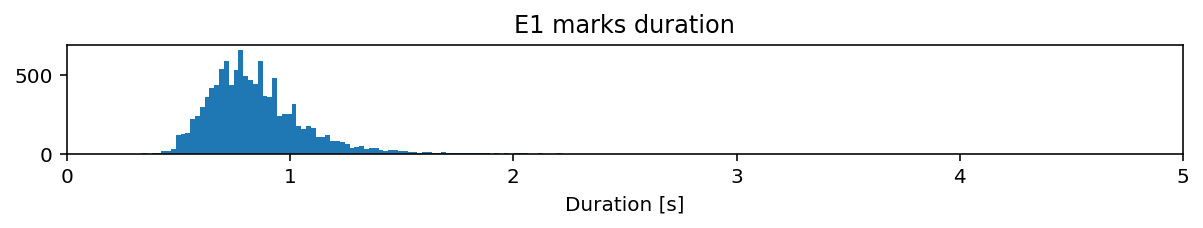

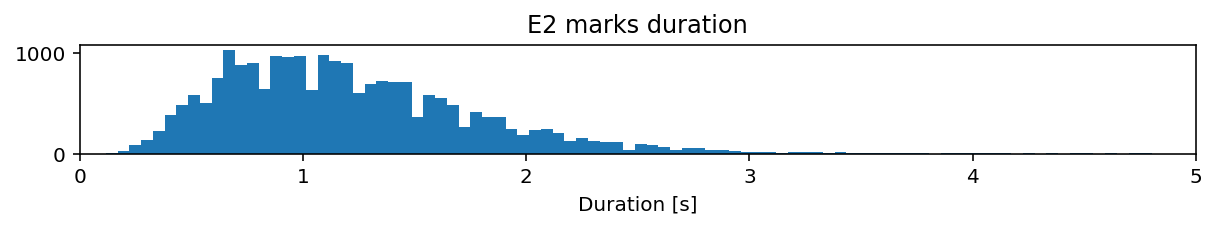

In [48]:
# Now lets read the spindle marks
reg_e1 = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
         '13', '14', '15', '16', '17', '18', '19']
duration_e1 = []
for i in range(len(reg_e1)):
    reg = reg_e1[i]
    path_edf_file = "ssdata_mass/label/marks/e1/01-02-00"+reg+" SpindleE1.edf"
    file = pyedflib.EdfReader(path_edf_file)
    annotations = file.readAnnotations()
    durations = np.array(annotations[1])
    duration_e1.append(durations)
    file._close()
e1_dur = np.concatenate(duration_e1)
idx_outlier = np.where(e1_dur>3)[0]
print("Number of marks greater than 3[s]:", len(idx_outlier),"with duration", e1_dur[idx_outlier])
# Remove this outliers
e1_dur_clean = np.delete(e1_dur, idx_outlier, None)
print("E1 total marks:",e1_dur.shape)
print("Min duration:",np.min(e1_dur_clean))
print("Mean duration:",np.mean(e1_dur_clean))
print("Median duration:",np.median(e1_dur_clean))
plt.figure(figsize=(10, 1))
plt.hist(e1_dur_clean, bins='auto')  # arguments are passed to np.histogram
plt.title("E1 marks duration")
plt.xlabel("Duration [s]")
plt.xlim([0,5])
plt.show()

reg_e2 = ['01', '02', '03', '05', '06', '07', '09', '10', '11', '12',
     '13', '14', '17', '18', '19']
duration_e2 = []
for i in range(len(reg_e2)):
    reg = reg_e2[i]
    path_edf_file = "ssdata_mass/label/marks/e2/01-02-00"+reg+" SpindleE2.edf"
    file = pyedflib.EdfReader(path_edf_file)
    annotations = file.readAnnotations()
    durations = np.array(annotations[1])
    duration_e2.append(durations)
    file._close()
e2_dur = np.concatenate(duration_e2)
idx_3 = np.where(e2_dur>3)[0]
idx_4 = np.where(e2_dur>4)[0]
idx_5 = np.where(e2_dur>5)[0]
#print("Number of marks greater than 3[s]:", len(idx_3))
#print("Number of marks greater than 4[s]:", len(idx_4))
#print("Number of marks greater than 5[s]:", len(idx_5),"with duration", e2_dur[idx_5])
# Remove this outliers
e2_dur_clean = np.delete(e2_dur, idx_5, None)
#print("E2 total marks:",e2_dur.shape)
#print("Min duration:",np.min(e2_dur))
#print("Mean duration:",np.mean(e2_dur_clean))
#print("Median duration:",np.median(e2_dur))
plt.figure(figsize=(10, 1))
plt.hist(e2_dur_clean, bins='auto')  # arguments are passed to np.histogram
plt.xlim([0,5])
plt.title("E2 marks duration")
plt.xlabel("Duration [s]")
plt.show()

In [89]:
path_edf_file = "ssdata_mass/label/marks/01-02-0001 SpindleE1.edf"
file = pyedflib.EdfReader(path_edf_file)
print("register 1:", file.annotations_in_file)
annotations = file.readAnnotations()
file._close()

register 1: 1044


<class 'tuple'>
3
annotation: onset is 917.734376    
duration is 0.847602844238    
description is <Event channel="EEG C3-LER" groupName="spindle" name="spindleE1" scoringType="manual"/>


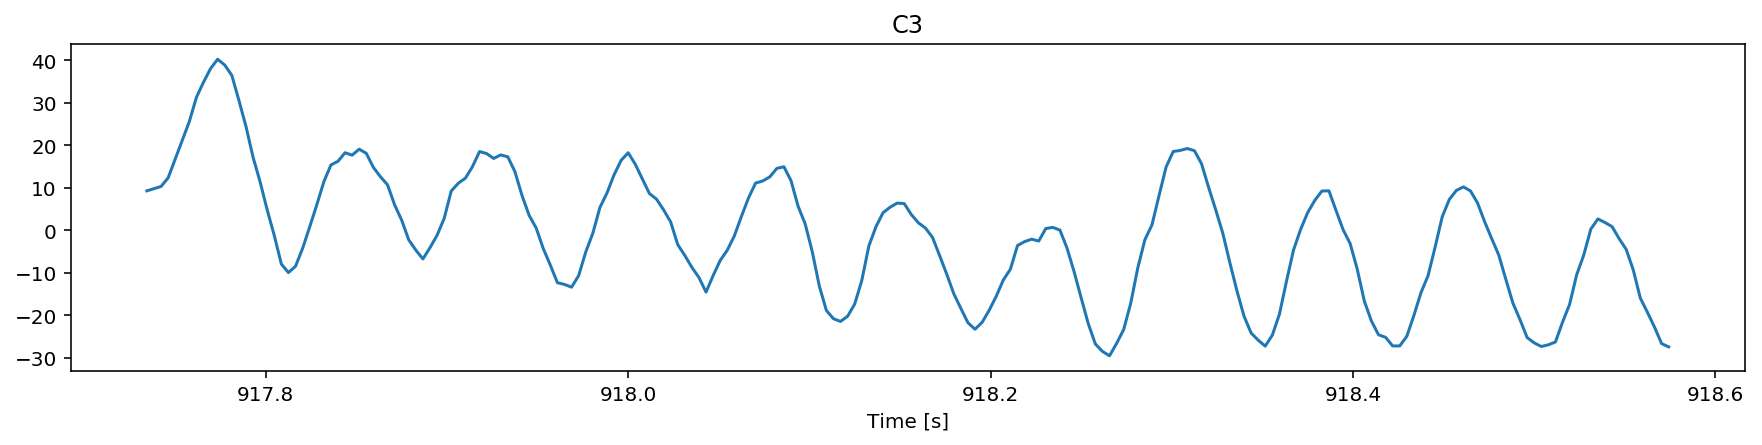

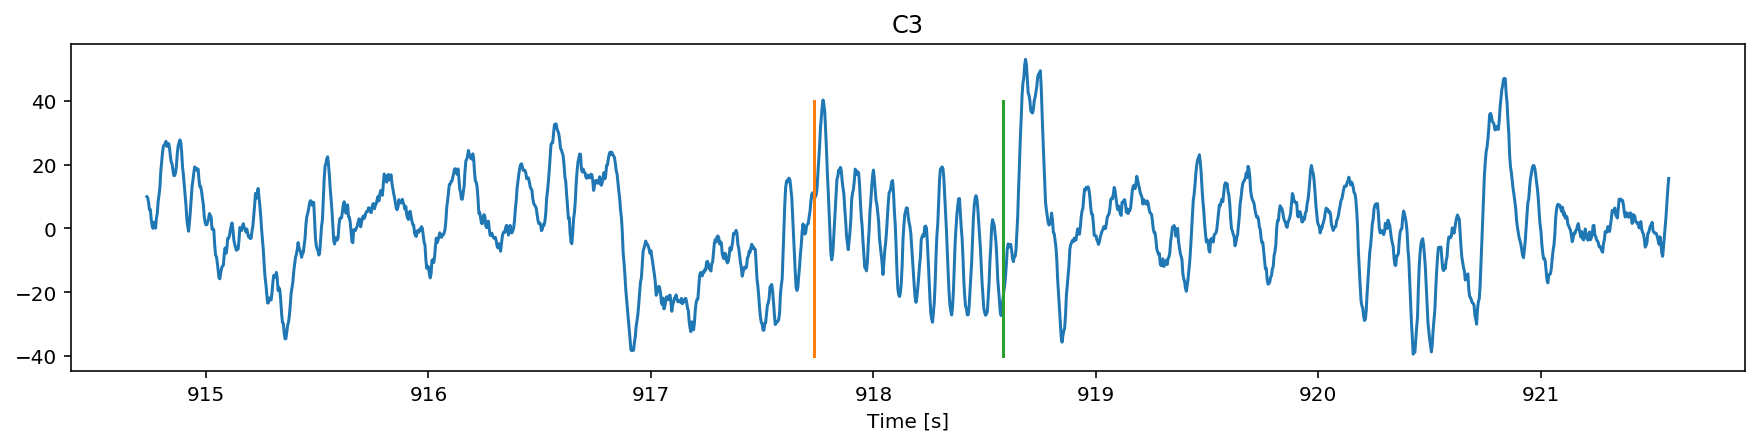

In [101]:
print(type(annotations)) #<class 'tuple'>
print(len(annotations))  # 3
# First is onset in seconds
# Second is duration in seconds
# third describe channel (C3-LER), type spindle, expert E1.

n = 2
print("annotation: onset is %f    \nduration is %s    \ndescription is %s" % (annotations[0][n],annotations[1][n],annotations[2][n]))

# Let's see a spindle
onset = annotations[0][n]
offset = onset + annotations[1][n]

onset_idx = int(onset*fs)
offset_idx = int(offset*fs)

plt.figure(figsize=(15, 3))
plt.plot(time_axis[onset_idx:offset_idx], signal_C3[onset_idx:offset_idx])
plt.title('C3')
plt.xlabel('Time [s]')
plt.show()

# Let add some temporal context
onset_idx = int((onset-3)*fs)
offset_idx = int((offset+3)*fs)

plt.figure(figsize=(15, 3))
plt.plot(time_axis[onset_idx:offset_idx], signal_C3[onset_idx:offset_idx])
plt.plot([onset, onset],[-40,40])
plt.plot([offset, offset],[-40,40])
plt.title('C3')
plt.xlabel('Time [s]')
plt.show()

In [25]:
# Every stages
reg = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
         '13', '14', '15', '16', '17', '18', '19']
for i in range(len(reg)):
    path_edf_file = "ssdata_mass/register/01-02-00"+reg[i]+" PSG.edf"
    file = pyedflib.EdfReader(path_edf_file)
    signal = file.readSignal(channel_C3)
    dur_signal = (len(signal)/256)
    print("Reg",i+1,"Duration in seconds:", dur_signal)
    file._close()
    path_edf_file = "ssdata_mass/label/states/01-02-00"+reg[i]+" Base.edf"
    file = pyedflib.EdfReader(path_edf_file)
    annotations = file.readAnnotations()
    for n in range(len(annotations[0])):
        if annotations[1][n] > 20:
            print("annotation: onset is %f    duration is %s    description is %s"
                  % (annotations[0][n],annotations[1][n],annotations[2][n]))
        if annotations[0][n] > (dur_signal-20):
            print("annotation: onset is %f    duration is %s    description is %s"
                  % (annotations[0][n],annotations[1][n],annotations[2][n]))
    file._close()

Reg 1 Duration in seconds: 28958.0
Reg 2 Duration in seconds: 35020.0
Reg 3 Duration in seconds: 36764.0
Reg 4 Duration in seconds: 28006.0
Reg 5 Duration in seconds: 31246.0
Reg 6 Duration in seconds: 28992.0
annotation: onset is 36140.917640    duration is 19.9948120117    description is Sleep stage ?
annotation: onset is 36160.916640    duration is 19.9987182617    description is Sleep stage ?
annotation: onset is 36180.918640    duration is 19.9948120117    description is Sleep stage ?
annotation: onset is 36200.917640    duration is 19.9948120117    description is Sleep stage ?
annotation: onset is 36220.916640    duration is 19.9987182617    description is Sleep stage ?
annotation: onset is 36240.918640    duration is 19.9948120117    description is Sleep stage ?
annotation: onset is 36260.917640    duration is 19.9948120117    description is Sleep stage ?
annotation: onset is 36280.916640    duration is 19.9987258911    description is Sleep stage ?
annotation: onset is 36300.918

In [26]:
# Find N2 stages
# Just ask if they are marked with '2', because they don't have any problems (being outside or with greater/less duration)
reg = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
         '13', '14', '15', '16', '17', '18', '19']
for i in range(len(reg)):
    path_edf_file = "ssdata_mass/label/states/01-02-00"+reg[i]+" Base.edf"
    file = pyedflib.EdfReader(path_edf_file)
    annotations = file.readAnnotations()
    stages_str = annotations[2]
    stages_char = [single_annot[-1] for single_annot in stages_str]
    n_epochs = len(stages_char)
    n2_epochs = np.zeros(n_epochs, dtype=np.int32)
    for i in range(n_epochs):
        if stages_char[i] == '2':
            n2_epochs[i] = 1
    print(np.sum(n2_epochs))
    file._close()

745
911
496
716
633
676
694
546
739
696
638
689
818
730
504
523
797
735
804


In [ ]:
# TODO:

# Make a table in which we compute
# reg id: n_epochs, n2_epochs, n_marks_E1, n_marks_E2

# Transform the files to the following arrays (and I can save them and share them to Rosario):
# say that is the channel C3-CLE, 256Hz.
# marks of both experts in the format start_sample end_sample
# stages as a single vector in the format (for the absent stages just fill with ?)
#      {'1', 2', '3', '4', 'R', 'W', '?'}  ->  1,2,3,4, 5,6, 7
# save both as .txt files.

# Compute histogram of duration of marks for each expert. min and max duration too.